In [47]:
import sys
import numpy as np
import pydicom as pd
import cv2 as cv
from scipy import ndimage
from skimage import feature
from skimage import exposure
from skimage import transform
from matplotlib import cm, pyplot as plt
from skimage.color import gray2rgb, rgb2hsv, rgb2lab, rgb2xyz, rgb2yuv, gray2rgba
from skimage.util import img_as_ubyte
from skimage import data, img_as_float
from scipy.integrate import trapz, simps
from skimage.segmentation import felzenszwalb, slic, find_boundaries, random_walker
from skimage.filters import threshold_otsu, unsharp_mask, gaussian, sobel
from skimage.filters.edges import convolve
from skimage.filters.rank import median, maximum, minimum ,autolevel_percentile, autolevel
from skimage.morphology import erosion, dilation, closing, disk
from skimage.restoration import denoise_bilateral
from ipywidgets import interact, IntSlider, interactive, fixed

In [3]:
def display_hist(ima,nbin):
    hist,bins = np.histogram(ima.flatten(),bins=range(0,nbin+1))
    plt.figure(figsize=[10,3])
    ax = plt.subplot(1,2,1)
    plt.imshow(ima,cmap=cm.gray,interpolation='nearest')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax = plt.subplot(1,2,2)
    plt.bar(bins[:-1],hist,.8)
    if len(bins)<10:
        ax.set_xticks(bins[:-1])
        ax.set_xticklabels( bins[:-1] )
    plt.xlabel('gray level')
    plt.ylabel('occurence');

In [4]:
def f64_2_u8(img_stack):
    
    if len(img_stack.shape)==2:
        stretched = 255 * (img_stack / max(np.unique(img_stack)))
        new_stack = stretched.astype(np.uint8)
    
    elif len(img_stack.shape)==3:
        new_stack = np.empty(img_stack.shape, np.uint8)
        for i in range(len(img_stack)):
            stretched = 255 * (img_stack[i] / max(np.unique(img_stack[i])))
            new_stack[i] = stretched.astype(np.uint8)
    
    else:
        raise ValueError('Array of wrong number of dimentions given to f64_2_u8')
    
    return(new_stack)

# Importation

0 	 2973 	 2074 	 1329.92
1 	 42976 	 31162 	 33866.51
2 	 42314 	 35543 	 35597.36
3 	 34511 	 32628 	 30751.19
4 	 37322 	 32012 	 31898.11
5 	 37532 	 31055 	 31447.36
6 	 37963 	 30787 	 31480.41
7 	 38754 	 29809 	 31377.32
8 	 39439 	 29155 	 31069.88
9 	 40202 	 28849 	 31145.34
10 	 40376 	 28124 	 30722.75
11 	 41067 	 28003 	 30997.38
12 	 41433 	 28396 	 31268.68
13 	 41839 	 27855 	 31041.9
14 	 42243 	 27818 	 31135.79
15 	 42749 	 27416 	 31045.77
16 	 43278 	 27353 	 31281.54
17 	 44089 	 27280 	 31352.08
18 	 44314 	 27158 	 31424.83
19 	 45006 	 26732 	 31339.8
20 	 45159 	 26683 	 31285.35
21 	 45840 	 26651 	 31606.75
22 	 45944 	 26269 	 31395.85
23 	 46602 	 26502 	 31680.41
24 	 46902 	 26072 	 31511.9
25 	 47313 	 26117 	 31656.52
26 	 47275 	 26261 	 31699.98
27 	 47874 	 25669 	 31399.58
28 	 48034 	 25682 	 31519.87
29 	 48585 	 25914 	 31831.91
30 	 48939 	 25445 	 31688.26
31 	 49199 	 25454 	 31704.29
32 	 49993 	 25631 	 31990.33
33 	 50280 	 25525 	 32050

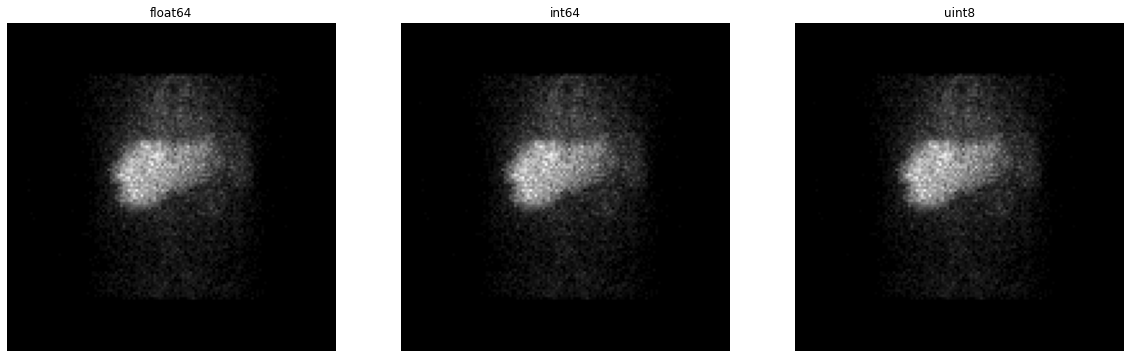

In [5]:
ant = pd.dcmread("Images/Dyn_Ant_HBS1.dcm")
post = pd.dcmread("Images/Dyn_Post_HBS1.dcm")
ant_pix = ant.pixel_array
post_pix = post.pixel_array[:,:,::-1]
mean = (ant_pix*post_pix)**(1/2)
for i in range(len(mean)):
    print(i, '\t', np.sum(ant_pix[i]), '\t', np.sum(post_pix[i]), '\t', round(np.sum(mean[i]),2))
print('Tot', '\t', np.sum(ant_pix), np.sum(post_pix), '', round(np.sum(mean),2))
    
print("Number of levels as {} =".format(mean.dtype), len(np.unique(mean)))

mean_int = np.rint(mean).astype(int)
#mean_int = mean / max(np.unique(mean))
#mean_int = 255 * mean_int
#mean_int = mean_int.astype(np.uint8)
print("Number of levels as {} =".format(mean_int.dtype), len(np.unique(mean_int)))

mean_norm = mean / max(np.unique(mean))
mean_norm = 255 * mean_norm
mean_norm = mean_norm.astype(np.uint8)
print("Number of levels as {} =".format(mean_norm.dtype), len(np.unique(mean_norm)))


plt.figure(figsize=[20,20])
plt.subplot(1,3,1)
plt.title(str(mean.dtype))
plt.axis('off')
plt.imshow(mean[25],cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.title(str(mean_int.dtype))
plt.axis('off')
plt.imshow(mean_int[25],cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.title(str(mean_norm.dtype))
plt.axis('off')
plt.imshow(mean_norm[25],cmap=plt.cm.gray)
plt.show()

In [6]:
@interact(i=IntSlider(min=0, max=35, step=1, value=0),
         mask=fixed(None), shift=fixed(None))

def show_im(i, mask, shift):
    if shift and shift[i]:
        mask = ndimage.shift(mask, [shift[i],0])
        mask = closing(mask,disk(3))
        mask = np.ma.masked_where(mask==0, mask)
    plt.figure(figsize=[15,15])
    plt.subplot(1,3,1)
    plt.axis('off')
    plt.title('Ant')
    plt.imshow(ant_pix[i,:,:],cmap=plt.cm.gray)
    plt.subplot(1,3,2)
    plt.axis('off')
    plt.title('Post')
    plt.imshow(post_pix[i,:,:],cmap=plt.cm.gray)
    plt.subplot(1,3,3)
    plt.axis('off')
    plt.title('Mean')
    plt.imshow(mean[i,:,:],cmap=plt.cm.gray)
    if mask is not None:
        plt.imshow(mask, cmap='coolwarm', alpha = 0.4)

interactive(children=(IntSlider(value=0, description='i', max=35), Output()), _dom_classes=('widget-interact',…

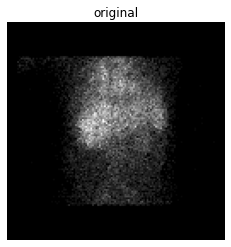

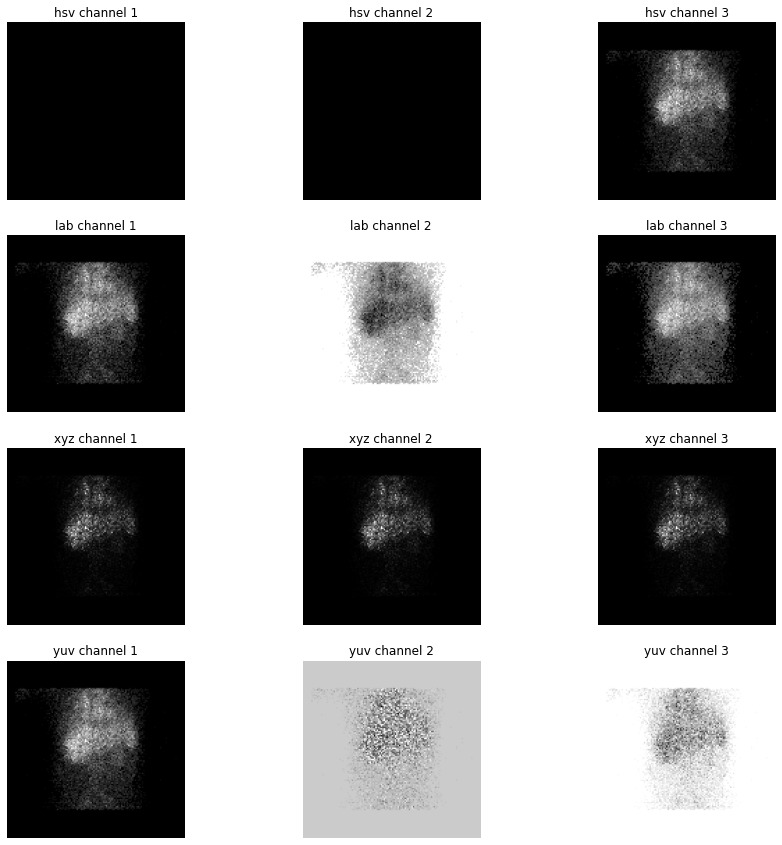

In [7]:
rgb = gray2rgb(f64_2_u8(mean_norm[9]))
hsv = rgb2hsv(rgb)
lab = rgb2lab(rgb)
xyz = rgb2xyz(rgb)
yuv = rgb2yuv(rgb)

plt.axis('off')
plt.title('original')
plt.imshow(rgb,cmap=plt.cm.gray)
plt.show()

plt.figure(figsize=[15,15])
plt.subplot(4,3,1)
plt.axis('off')
plt.title('hsv channel 1')
plt.imshow(hsv[:,:,0],cmap=plt.cm.gray)
plt.subplot(4,3,2)
plt.axis('off')
plt.title('hsv channel 2')
plt.imshow(hsv[:,:,1],cmap=plt.cm.gray)
plt.subplot(4,3,3)
plt.axis('off')
plt.title('hsv channel 3')
plt.imshow(hsv[:,:,2],cmap=plt.cm.gray)

plt.subplot(4,3,4)
plt.axis('off')
plt.title('lab channel 1')
plt.imshow(lab[:,:,0],cmap=plt.cm.gray)
plt.subplot(4,3,5)
plt.axis('off')
plt.title('lab channel 2')
plt.imshow(lab[:,:,1],cmap=plt.cm.gray)
plt.subplot(4,3,6)
plt.axis('off')
plt.title('lab channel 3')
plt.imshow(lab[:,:,2],cmap=plt.cm.gray)

plt.subplot(4,3,7)
plt.axis('off')
plt.title('xyz channel 1')
plt.imshow(xyz[:,:,0],cmap=plt.cm.gray)
plt.subplot(4,3,8)
plt.axis('off')
plt.title('xyz channel 2')
plt.imshow(xyz[:,:,1],cmap=plt.cm.gray)
plt.subplot(4,3,9)
plt.axis('off')
plt.title('xyz channel 3')
plt.imshow(xyz[:,:,2],cmap=plt.cm.gray)

plt.subplot(4,3,10)
plt.axis('off')
plt.title('yuv channel 1')
plt.imshow(yuv[:,:,0],cmap=plt.cm.gray)
plt.subplot(4,3,11)
plt.axis('off')
plt.title('yuv channel 2')
plt.imshow(yuv[:,:,1],cmap=plt.cm.gray)
plt.subplot(4,3,12)
plt.axis('off')
plt.title('yuv channel 3')
plt.imshow(yuv[:,:,2],cmap=plt.cm.gray)
plt.show()

# Liver segmentation

(128, 128)
float64
Number of levels = 454
(128, 128)
float64
Number of levels = 4879
Number of levels as uint8 = 240


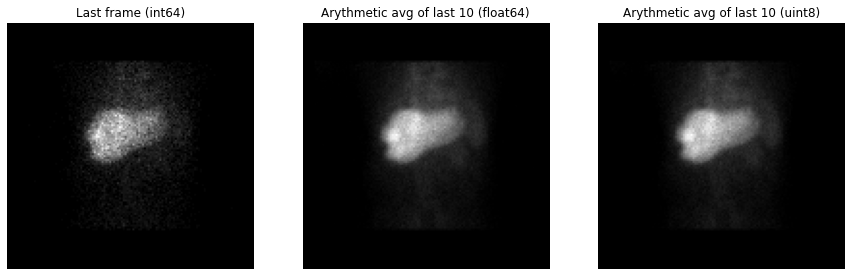

In [8]:
#Build avg of last 10

img = mean[35,:,:]
print(img.shape)
print(img.dtype)
print("Number of levels =", len(np.unique(img)))
img = img.astype(int)

avg = np.zeros(img.shape, dtype=np.float64)
for i in range(len(mean[-10:])):
    avg += mean[-i]
avg = avg/10
print(avg.shape)
print(avg.dtype)
print("Number of levels =", len(np.unique(avg)))

avg_norm = 255 * (avg / max(np.unique(avg)))
avg_norm = avg_norm.astype(np.uint8)
print("Number of levels as {} =".format(avg_norm.dtype), len(np.unique(avg_norm)))

plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.axis('off')
plt.title("Last frame ({})".format(img.dtype))
plt.imshow(img, cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.axis('off')
plt.title("Arythmetic avg of last 10 ({})".format(avg.dtype))
plt.imshow(avg, cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.axis('off')
plt.title("Arythmetic avg of last 10 ({})".format(avg_norm.dtype))
plt.imshow(avg_norm, cmap=plt.cm.gray)
plt.show()

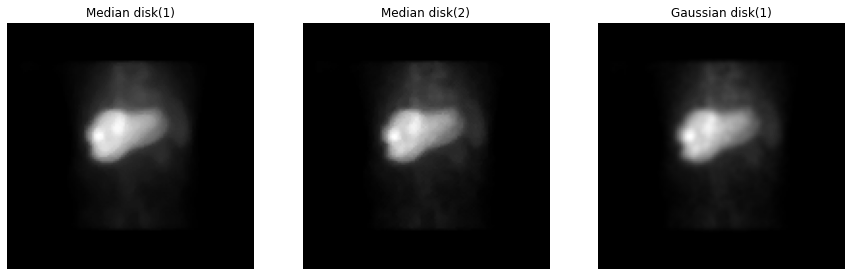

In [10]:
img_median = median(avg_norm, disk(3))
img_gauss = f64_2_u8(gaussian(avg_norm,1))

plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.title("Median disk(1)")
plt.axis('off')
plt.imshow(img_median, cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.title("Median disk(2)")
plt.axis('off')
plt.imshow(median(avg_norm, disk(2)), cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.title("Gaussian disk(1)")
plt.axis('off')
plt.imshow(img_gauss, cmap=plt.cm.gray)
plt.show()

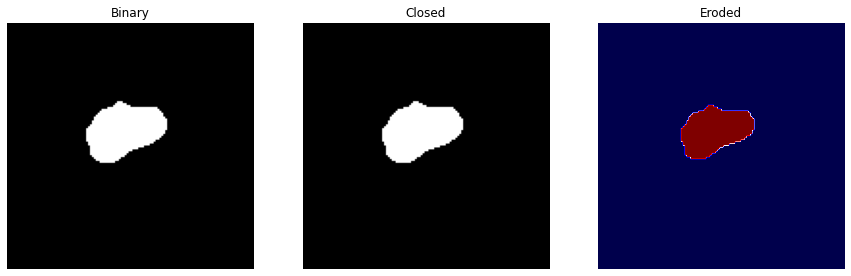

In [11]:
thresh = threshold_otsu(img_median)-10

binary = img_median > thresh
closed = closing(binary, disk(2))
eroded = erosion(binary, disk(2))

plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.title("Binary")
plt.axis('off')
plt.imshow(binary, cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.title("Closed")
plt.axis('off')
plt.imshow(closed, cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.title("Eroded")
plt.axis('off')
plt.imshow(mean[35], cmap=plt.cm.gray)
plt.imshow(eroded, cmap='seismic')
plt.show()

/Users/olivier/anaconda3/lib/python3.7/site-packages/skimage/filters/rank/_percentile.py:40: UserWarning: Bad rank filter performance is expected due to a large number of bins (65536), equivalent to an approximate bitdepth of 16.0.
  out_dtype)
/Users/olivier/anaconda3/lib/python3.7/site-packages/skimage/filters/rank/generic.py:183: UserWarning: Bad rank filter performance is expected due to a large number of bins (65536), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


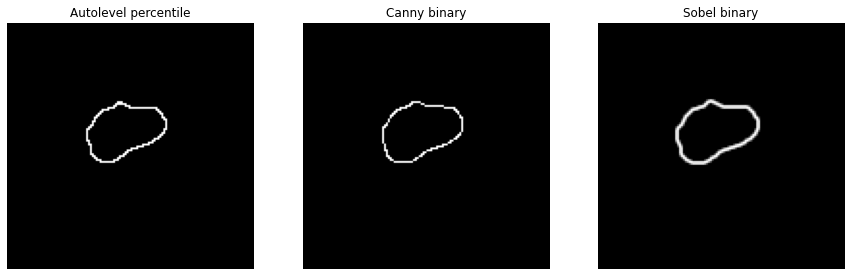

In [21]:
from skimage import img_as_uint

canny_binary = feature.canny(binary)
sobel_binary = sobel(binary)
border = autolevel_percentile(img_as_uint(binary),disk(2),p0=.1,p1=.9)

plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.axis('off')
plt.title("Autolevel percentile")
plt.imshow(median(border, disk(1)), cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.axis('off')
plt.title("Canny binary")
plt.imshow(canny_binary, cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.axis('off')
plt.title("Sobel binary")
plt.imshow(sobel_binary, cmap=plt.cm.gray)
plt.show()

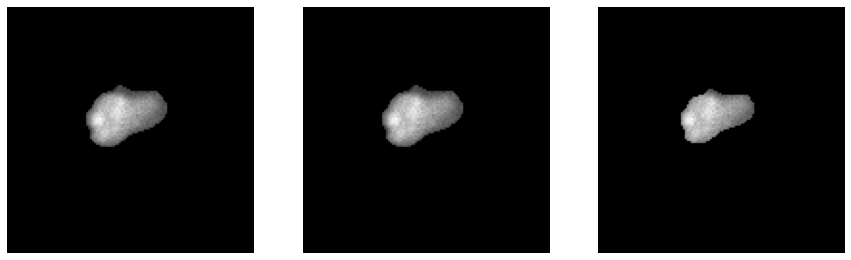

In [13]:
masked_img = avg_norm * binary
masked_closed = avg_norm * closed
masked_eroded = avg_norm * eroded

plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(masked_img, cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(masked_closed, cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(masked_eroded, cmap=plt.cm.gray)
plt.show()

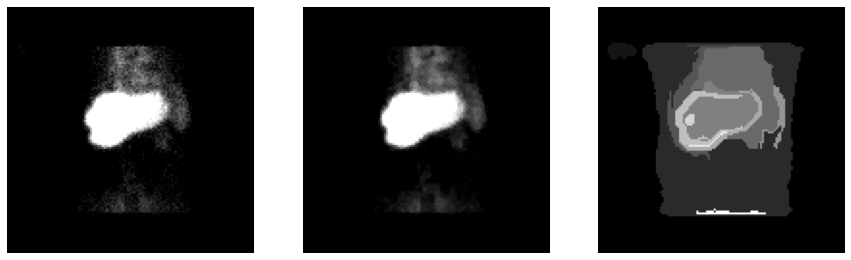

In [14]:
img_local1 = unsharp_mask(avg_norm, radius=20, amount=3)
img_local2 = unsharp_mask(median(avg_norm,disk(1)), radius=20, amount=3)
img_cluster = felzenszwalb(median(avg_norm, disk(2)), scale=100, sigma=0.5)

canny1 = feature.canny(img_local1, sigma=1)
canny2 = feature.canny(img_local2, sigma=1)


plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(img_local1, cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(img_local2, cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(img_cluster, cmap=plt.cm.gray)
plt.show()

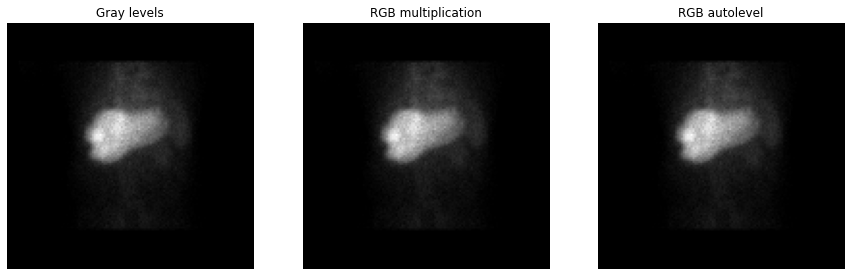

In [15]:
#RGB transform
img_rgb = gray2rgb(avg_norm)

#img_rgb2 = gray2rgb(np.rint(img_autolev).astype(int))
#print(np.unique(img_rgb2), len(np.unique(img_rgb2)))

plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.title("Gray levels")
plt.axis('off')
plt.imshow(avg_norm, cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.title("RGB multiplication")
plt.axis('off')
plt.imshow(img_rgb)
plt.subplot(1,3,3)
plt.title("RGB autolevel")
plt.axis('off')
plt.imshow(img_rgb)
plt.show()

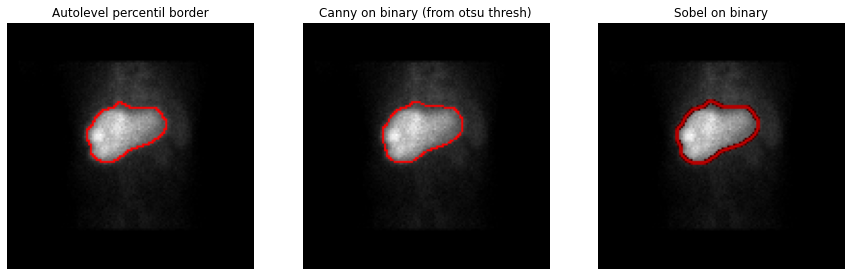

In [22]:
rgb_masked_bin = img_rgb.copy()
rgb_masked_auto = img_rgb.copy()
rgb_masked_so = img_rgb.copy()
for i in range(128):
    for j in range(128):
        if canny_binary[i,j]:
            rgb_masked_bin[i,j] = [255,0,0]
        if sobel_binary[i,j]:
            rgb_masked_so[i,j] = [sobel_binary[i,j]*255,0,0]
        if border[i,j]:
            rgb_masked_auto[i,j] = [255,0,0]

plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.axis('off')
plt.title("Autolevel percentil border")
plt.imshow(rgb_masked_auto)
plt.subplot(1,3,2)
plt.axis('off')
plt.title("Canny on binary (from otsu thresh)")
plt.imshow(rgb_masked_bin)
plt.subplot(1,3,3)
plt.axis('off')
plt.title("Sobel on binary")
plt.imshow(rgb_masked_so)
plt.show()

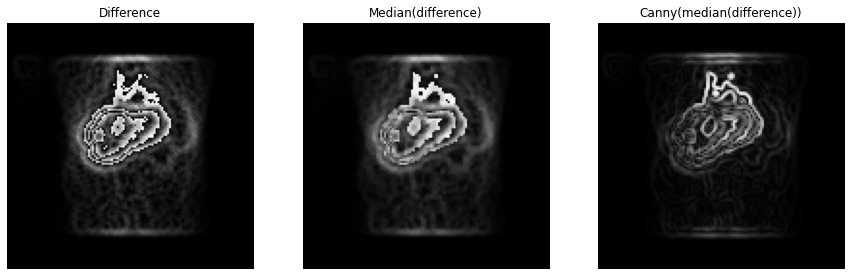

In [23]:
conv1 = convolve(avg_norm, disk(1))
conv2 = dilation(conv1, disk(3))
diff = conv2-conv1
diff_med = median(diff, disk(1))

plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.axis('off')
plt.title("Difference")
plt.imshow(diff, cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.axis('off')
plt.title("Median(difference)")
plt.imshow(diff_med, cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.axis('off')
plt.title("Canny(median(difference))")
plt.imshow(sobel(diff_med), cmap=plt.cm.gray)
plt.show()

/Users/olivier/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


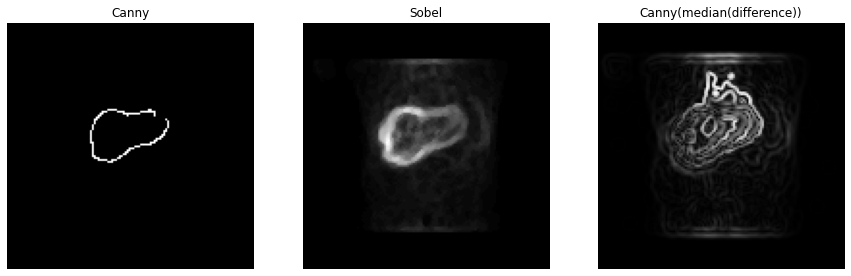

In [24]:
can = feature.canny(avg_norm, sigma=1.5, low_threshold=70, high_threshold=200)
sob = median(sobel(avg_norm),disk(2))

plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.axis('off')
plt.title("Canny")
plt.imshow(can, cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.axis('off')
plt.title("Sobel")
plt.imshow(sob, cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.axis('off')
plt.title("Canny(median(difference))")
plt.imshow(sobel(diff_med), cmap=plt.cm.gray)
plt.show()

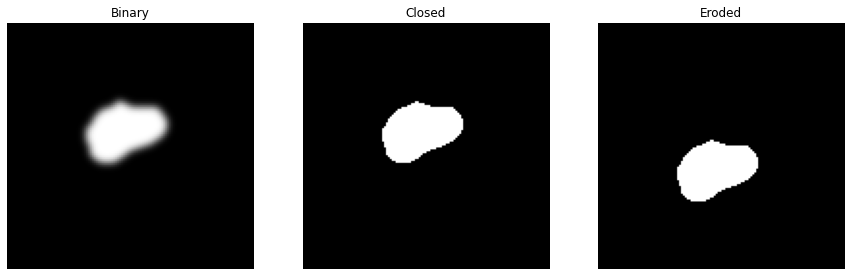

In [50]:
#binary edge smoohing
binary_gauss = gaussian(binary,2)
thresh_bis = threshold_otsu(binary_gauss)
binary_sm = binary_gauss > thresh_bis

plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.title("Binary")
plt.axis('off')
plt.imshow(binary_gauss, cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.title("Closed")
plt.axis('off')
plt.imshow(binary_sm, cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.title("Eroded")
plt.axis('off')
#plt.imshow(mean[25], cmap=plt.cm.gray)
#plt.imshow(np.ma.masked_where(binary_sm==0, binary_sm), cmap="coolwarm")

matrix = transform.EuclideanTransform(translation = (0, 20))
binary_sm = transform.warp(binary_sm, matrix.inverse)

#binary_sm = ndimage.shift(binary_sm, [20,-10])
#binary_sm = closing(binary_sm,disk(3))
plt.imshow(binary_sm, cmap=plt.cm.gray)
plt.show()

# Blood pool segmentation

(128, 128)
Number of levels as uint8 = 170


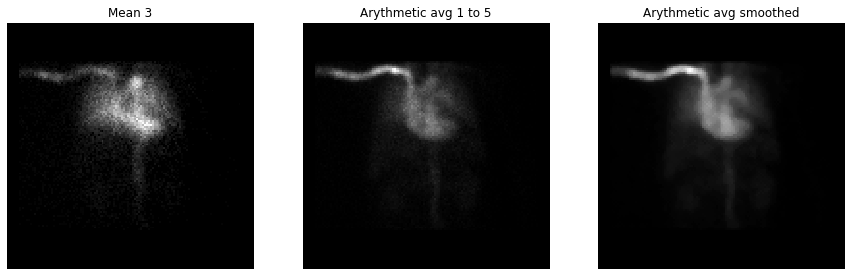

In [66]:
avg_blood = np.zeros(img.shape, dtype=np.float64)
for i in ant_pix[2:6]:
    avg_blood += i
avg_blood = avg_blood/len(mean[2:6])
print(avg_blood.shape)

avg_blood_norm = 255 * (avg_blood / max(np.unique(avg_blood)))
avg_blood_norm = avg_blood_norm.astype(np.uint8)
print("Number of levels as {} =".format(avg_blood_norm.dtype), len(np.unique(avg_blood_norm)))

blood_med = median(avg_blood_norm, disk(2))

plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.axis('off')
plt.title("Mean 3")
plt.imshow(mean[3], cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.axis('off')
plt.title("Arythmetic avg 1 to 5")
plt.imshow(avg_blood_norm, cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.axis('off')
plt.title("Arythmetic avg smoothed")
plt.imshow(blood_med, cmap=plt.cm.gray)
plt.show()

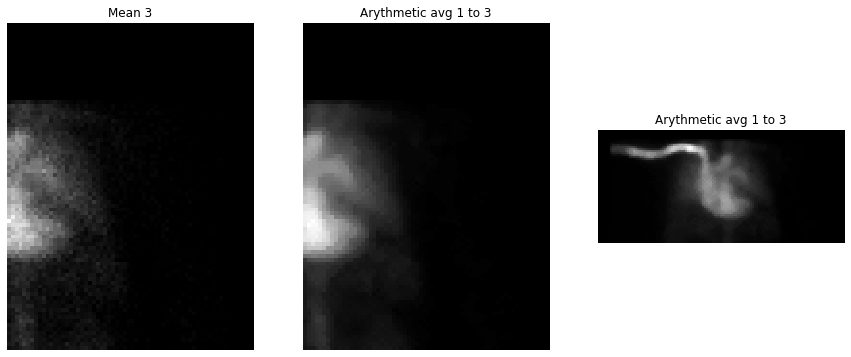

In [67]:
plt.figure(figsize=[15,15])
plt.subplot(1,3,1)
plt.axis('off')
plt.title("Mean 3")
plt.imshow(avg_blood_norm[:2*128//3,128//2:], cmap=plt.cm.gray)
plt.subplot(1,3,2)
plt.axis('off')
plt.title("Arythmetic avg 1 to 3")
plt.imshow(blood_med[:2*128//3,128//2:], cmap=plt.cm.gray)
plt.subplot(1,3,3)
plt.axis('off')
plt.title("Arythmetic avg 1 to 3")
plt.imshow(blood_med[15:128//2+10,:], cmap=plt.cm.gray)
plt.show()

In [68]:
from skimage import data
from skimage.draw import ellipse
from skimage.color import rgb2gray
from skimage.segmentation import active_contour

def get_white(img):
    bin = np.full_like(img,1)
    for i in range(len(img)):
        for j in range(len(img[i])):
            if img[i,j] >= 0.9:
                bin[i,j]=2
    return(bin)

def get_white_modif(img):
    bin = np.full_like(img,0)
    for i in range(len(img)):
        start = False
        end = False
        for j in range(len(img[i])):
            if (start or img[j,i] >= 0.95)and not end:
                start=True
                bin[j,i]=1
            if img[j,i] < 0.95 and start:
                end = True
    return(bin)

@interact(rad=IntSlider(min=0, max=50, step=1, value=15),  
          am=IntSlider(min=0, max=50, step=1, value=15),
          thresh=IntSlider(min=0, max=255, step=1, value=100))

def show_articles_more_than(rad, am, thresh):
    ell = np.zeros((128, 128), dtype=np.uint8)
    rr, cc = ellipse(45, 66, 20, 25, rotation=np.deg2rad(0))
    ell[rr, cc] = 1
    
    blood1 = unsharp_mask(avg_blood_norm*ell, radius=rad, amount=am)
    blood2 = unsharp_mask(blood_med*ell, radius=rad, amount=am)
    b_thresh = threshold_otsu(blood_med*ell)
    b_mask = blood2 > 0.9*max(np.unique(blood2))
    bb_mask = blood_med*ell > thresh

    plt.figure(figsize=[13,8])
    plt.subplot(2,3,1)
    plt.axis('off')
    plt.title("avg med")
    plt.imshow(blood_med, cmap=plt.cm.gray)
    
    plt.subplot(2,3,2)
    plt.axis('off')
    plt.title("Unsharp mask on median")
    plt.imshow(blood2, cmap=plt.cm.gray)
    
    plt.subplot(2,3,3)
    plt.axis('off')
    plt.title("Binary (10% highest)")
    plt.imshow(closing(b_mask,disk(3)), cmap=plt.cm.gray)
    
    plt.subplot(2,3,4)
    plt.axis('off')
    plt.title("Snake")
    plt.imshow(ell*blood_med, cmap=plt.cm.gray)
    
    plt.subplot(2,3,5)
    plt.axis('off')
    plt.title("Unsharp mask on median")
    plt.imshow(blood2, cmap=plt.cm.gray)
    
    plt.subplot(2,3,6)
    plt.axis('off')
    plt.title("Ellipse thresh")
    plt.imshow(closing(bb_mask,disk(3)), cmap=plt.cm.gray)
    plt.show()

interactive(children=(IntSlider(value=15, description='rad', max=50), IntSlider(value=15, description='am', ma…

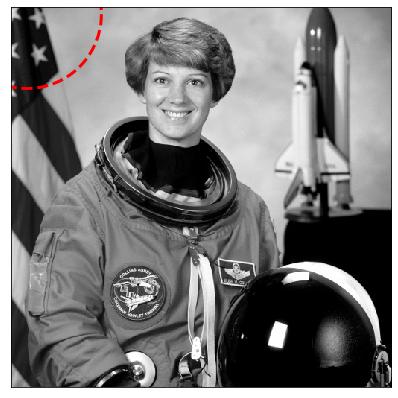

In [76]:
img = data.astronaut()
img = rgb2gray(img)

s = np.linspace(0, 2*np.pi, 400)
r = 100 + 100*np.sin(s)
c = 220 + 100*np.cos(s)
init = np.array([r, c]).T

snake = active_contour(gaussian(img, 3),
                       init, alpha=0.015, beta=10, gamma=0.001,coordinates='rc')

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])

plt.show()

# Liver uptake rate calcul

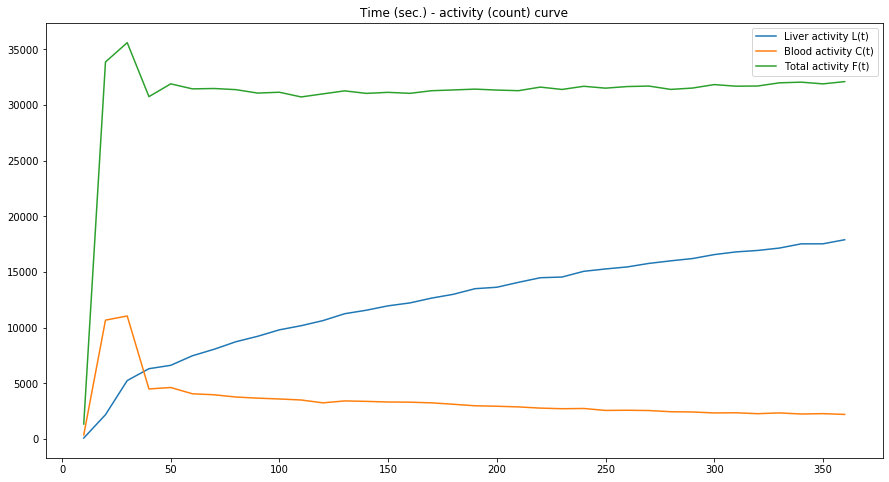

In [137]:
Lt = [75.22620206727042, 2171.6573873702037, 5240.058948964823, 6305.619571225982, 6607.721187184377, 
      7467.63367652685, 8053.170138852807, 8728.399722965907, 9216.42997469495, 9796.257192785464,
      10168.453806260755, 10624.295471130426, 11244.278590127613, 11559.879614734511, 11952.890712249471,
      12214.89474244861, 12648.103696731334, 12989.665926454853, 13493.978216861064, 13622.649235630475, 
      14066.917649478708, 14478.0181932679, 14542.018106621368, 15055.057892415993, 15266.997264601103, 
      15448.778303455118, 15767.03870079609, 15995.396593331285, 16200.973542529746, 16555.99972206792, 
      16799.543250210325, 16929.518449270337, 17144.46144060582, 17523.037645862783, 17525.437111308405, 
      17891.400293477927]

Ct = [351.7478164809896, 10668.544173216298, 11041.909114799568, 4484.668198489293, 4615.396316119048,
      4050.5709571712932, 3961.431601556106, 3758.899246596461, 3658.4869589222994, 3584.147897469105,
      3493.4851656959213, 3236.405206875266, 3409.554193212917, 3368.8555790379555, 3312.8815705198476,
      3296.167375905381, 3237.14336786035, 3109.0503908364, 2973.3958061535586, 2932.497745293502,
      2871.4733213814893, 2763.9361436574854, 2709.5256008464426, 2729.894468384449, 2556.0603424999467,
      2572.139191459586, 2546.353984364498, 2437.87357881079, 2415.9131966233995, 2329.807919957175,
      2345.0464706162034, 2261.6112781373927, 2332.7807017711716, 2233.532323806138, 2265.9857216221876,
      2197.9735204531275]

Ft = [1329.9157661663705, 33866.50767965961, 35597.35628606755, 30751.190575755667, 31898.107456356636,
      31447.3596818183, 31480.413591949604, 31377.319302048836, 31069.876190633655, 31145.344453515052,
      30722.75454881914, 30997.38099517003, 31268.679886806756, 31041.903015141776, 31135.78783291517,
      31045.77176539461, 31281.540568151828, 31352.083305213077, 31424.831097522976, 31339.79923302326,
      31285.354125446735, 31606.75220384242, 31395.846002779363, 31680.40515009864, 31511.89936071931,
      31656.517820026485, 31699.983655547407, 31399.58358705967, 31519.86707557144, 31831.91267752663,
      31688.262780412322, 31704.287466512564, 31990.330283461182, 32050.59106958875, 31896.500479975053,
      32100.04089303943]

time_steps = [10*(i+1) for i in range(36)]

plt.figure(figsize=[15,8])
plt.title('Time (sec.) - activity (count) curve')
plt.plot(time_steps, Lt, label = 'Liver activity L(t)')
plt.plot(time_steps, Ct, label = 'Blood activity C(t)')
plt.plot(time_steps, Ft, label = 'Total activity F(t)')
plt.legend()
plt.show()

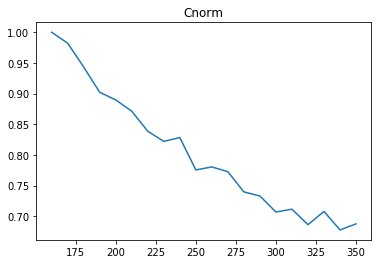

A(t1) : 22204.11463547662
Area under the curve : 152.1133688408396
Liver clearance rate : 10.08397%/min
Corrected uptake rate for BSA of 1.71m^2 : 5.90569%/min/m^2


In [138]:
def sec2min(sec):
    m = sec//60
    m += (sec%60)/60.0
    return(m)

def bsa(w,h):
    return((h*w/3600)**(1/2)) # Mosteller

def calcul_inte(ft1, ft2, lt1, lt2, ct, time_steps):
    Cnorm = np.array(ct)/ct[0]
    plt.plot(time_steps, Cnorm)
    plt.title('Cnorm')
    plt.show()

    At1 = (ft2-lt1-(ft1-lt1)*Cnorm[-1])/(1-Cnorm[-1]) #Ekman eq. 8
    print('A(t1) :', At1)

    integral = trapz(Cnorm, time_steps)
    print('Area under the curve :', integral)

    LClr = 60*(lt2-lt1)/(At1*integral) #Ekman eq. 4
    print('Liver clearance rate : {:.5f}%/min'.format(LClr*100))

    corrected = LClr/bsa(64, 164)
    print('Corrected uptake rate for BSA of {:.2f}m^2 : {:.5f}%/min/m^2'.format(bsa(64, 164), corrected*100))
    
calcul_inte(Ft[15], Ft[35], Lt[15], Lt[35], Ct[15:35], time_steps[15:35])

# Tc99m decay correction

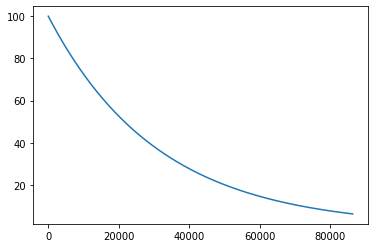

Time   Activity   Corr factor
150     0.9952      1.0048
160     0.9949      1.0051
170     0.9946      1.0055
180     0.9942      1.0058
190     0.9939      1.0061
200     0.9936      1.0064
210     0.9933      1.0068
220     0.9930      1.0071
230     0.9926      1.0074
240     0.9923      1.0077
250     0.9920      1.0081
260     0.9917      1.0084
270     0.9914      1.0087
280     0.9911      1.0090
290     0.9907      1.0093
300     0.9904      1.0097
310     0.9901      1.0100
320     0.9898      1.0103
330     0.9895      1.0106
340     0.9891      1.0110
350     0.9888      1.0113


In [139]:
l = 0.69315/(6*60*60)
x = [i for i in range(0,24*60*60,2)]
y = [100*np.exp(-l*i) for i in x]
plt.plot(x,y)
plt.show()

print('Time   Activity   Corr factor')
for i in time_steps[14:35]:
    print('{}     {:.4f}      {:.4f}'.format(i, 1*np.exp(-l*i), 1/np.exp(-l*i)))

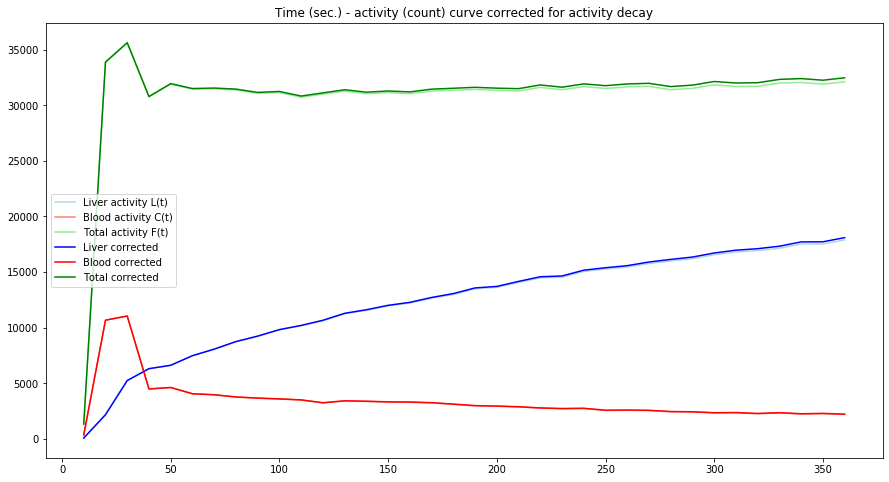

In [140]:
Lt_corr = [Lt[i]*(1/np.exp(-l*(time_steps[i]-5))) for i in range(len(time_steps))]
Ct_corr = [Ct[i]*(1/np.exp(-l*(time_steps[i]-5))) for i in range(len(time_steps))]
Ft_corr = [Ft[i]*(1/np.exp(-l*(time_steps[i]-5))) for i in range(len(time_steps))]

plt.figure(figsize=[15,8])
plt.title('Time (sec.) - activity (count) curve corrected for activity decay')
plt.plot(time_steps, Lt, label = 'Liver activity L(t)', color = 'lightblue')
plt.plot(time_steps, Ct, label = 'Blood activity C(t)', color = 'salmon')
plt.plot(time_steps, Ft, label = 'Total activity F(t)', color = 'lightgreen')
plt.plot(time_steps, Lt_corr, label = 'Liver corrected', color = 'blue')
plt.plot(time_steps, Ct_corr, label = 'Blood corrected', color = 'red')
plt.plot(time_steps, Ft_corr, label = 'Total corrected', color = 'green')
plt.legend()
plt.show()

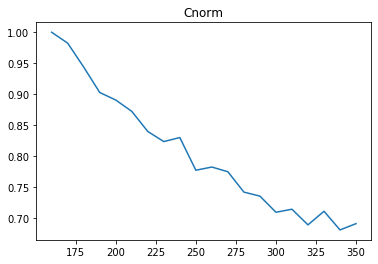

A(t1) : 23034.718979155863
Area under the curve : 152.5470863585596
Liver clearance rate : 9.93873%/min
Corrected uptake rate for BSA of 1.71m^2 : 5.82063%/min/m^2


In [141]:
calcul_inte(Ft_corr[15], Ft_corr[35], Lt_corr[15], Lt_corr[35], Ct_corr[15:35], time_steps[15:35])

# Uptake rate calcul with Bcl

C0 : 4507.91646
lambda : 0.00209
t1/2 : 332.03469

Blood clearence rate : 12.52544%/min
Liver clearance rate : 9.37745%/min

Blood corrected at : 7.33555%/min/m^2
Liver corrected rate for BSA of 1.71m^2 : 5.49192%/min/m^2


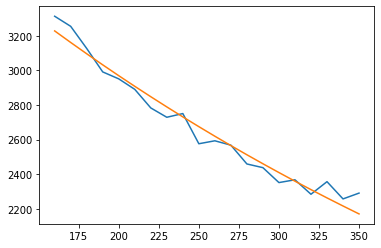

In [142]:
from scipy.optimize import curve_fit # BCl[t] = c0*e^(-l*t)

def calcul_fit_free(ct1, ct2, lt1, lt2, ft1, ft2, time_steps, ct):
    plt.plot(time_steps, ct)
    popt, pcov = curve_fit(lambda t,c0,l: c0*np.exp(-l*t), time_steps, ct,[3000, 0.001])
    print('C0 : {:.5f}'.format(popt[0]))
    print('lambda : {:.5f}'.format(popt[1]))
    plt.plot(time_steps, [popt[0]*np.exp(-popt[1]*i) for i in time_steps])
    tdemi = 0.693147/popt[1]
    print('t1/2 : {:.5f}'.format(tdemi))

    bcl = 0.693147/tdemi
    print()
    print('Blood clearence rate : {:.5f}%/min'.format(bcl*100*60))
    cnormt2 = ct2/ct1
    at1 = (ft2-lt1-(ft1-lt1)*cnormt2)/(1-cnormt2)
    inte = (np.exp(-bcl*150)-np.exp(-bcl*350))/(bcl*(np.exp(-bcl*150)))
    lcl = (lt2-lt1)/(at1*inte)

    print('Liver clearance rate : {:.5f}%/min'.format(lcl*100*60))
    print()
    print('Blood corrected at : {:.5f}%/min/m^2'.format(bcl*100*60/bsa(64, 164)))
    print('Liver corrected rate for BSA of {:.2f}m^2 : {:.5f}%/min/m^2'.format(bsa(64, 164), (lcl*100*60)/bsa(64, 164)))
    
calcul_fit_free(Ct_corr[15], Ct_corr[35], Lt_corr[15], Lt_corr[35], 
                 Ft_corr[15],  Ft_corr[35], time_steps[15:35], Ct_corr[15:35])

fixed C0 : 3312.60
lambda : 0.00090
t1/2 : 767.54377

Blood clearence rate : 5.41843%/min
Liver clearance rate : 8.37920%/min

Blood corrected at : 3.17331%/min/m^2
Liver corrected rate for BSA of 1.71m^2 : 4.90729%/min/m^2


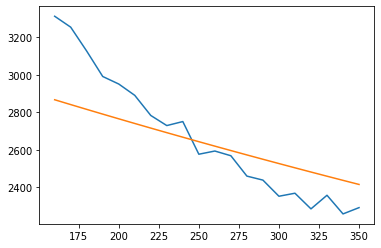

In [143]:
def calcul_fit_cons(ct1, ct2, lt1, lt2, ft1, ft2, time_steps, ct):
    plt.plot(time_steps, ct)
    popt, pcov = curve_fit(lambda t,l: ct1*np.exp(-l*t), time_steps, ct,[0.001])
    print('fixed C0 : {:.2f}'.format(ct1))
    print('lambda : {:.5f}'.format(popt[0]))
    plt.plot(time_steps, [ct1*np.exp(-popt[0]*i) for i in time_steps])
    tdemi = 0.693147/popt[0]
    print('t1/2 : {:.5f}'.format(tdemi))

    bcl = 0.693147/tdemi
    print()
    print('Blood clearence rate : {:.5f}%/min'.format(bcl*100*60))
    cnormt2 = ct2/ct1
    at1 = (ft2-lt1-(ft1-lt1)*cnormt2)/(1-cnormt2)
    inte = (np.exp(-bcl*150)-np.exp(-bcl*350))/(bcl*(np.exp(-bcl*150)))
    lcl = (lt2-lt1)/(at1*inte)

    print('Liver clearance rate : {:.5f}%/min'.format(lcl*100*60))
    print()
    print('Blood corrected at : {:.5f}%/min/m^2'.format(bcl*100*60/bsa(64, 164)))
    print('Liver corrected rate for BSA of {:.2f}m^2 : {:.5f}%/min/m^2'.format(bsa(64, 164), (lcl*100*60)/bsa(64, 164)))
    
calcul_fit_cons(Ct_corr[15], Ct_corr[35], Lt_corr[15], Lt_corr[35], 
                 Ft_corr[15],  Ft_corr[35], time_steps[15:35], Ct_corr[15:35])

# Respi adjustments

In [41]:
avg_last10_f64 = np.zeros(mean[-1].shape, dtype=np.float64)
for i in range(len(mean[-10:])):
    avg_last10_f64 += mean[-i]
avg_last10_f64 = avg_last10_f64/10
avg_last10_u8 = f64_2_u8(avg_last10_f64)
liv_med = median(avg_last10_u8, disk(2))
liv_thresh = threshold_otsu(liv_med)
liv_mask = liv_med > liv_thresh-10
liv_mask = closing(liv_mask, disk(3))
masked_liv = np.ma.masked_where(liv_mask==0, liv_mask)
shifted = [0 for i in range(len(mean))]

for im in range(len(mean)):
    tot = np.sum(masked_liv*mean[im])
    for i in range(1,6):
        shifted_liv = ndimage.shift(masked_liv, [i,0])
        shifted_liv = closing(shifted_liv,disk(3))
        shifted_liv = np.ma.masked_where(shifted_liv==0, shifted_liv)
        if np.sum(shifted_liv*mean[im])>tot:
            tot=np.sum(shifted_liv*mean[im])
            print('{} shifted to {}'.format(im, i))
            shifted[im] = i

print(shifted)
interact(show_im,i=IntSlider(min=0, max=35, step=1, value=0),
         mask=fixed(masked_liv), shift=fixed(shifted))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


interactive(children=(IntSlider(value=0, description='i', max=35), Output()), _dom_classes=('widget-interact',…

<function __main__.show_im(i, mask, shift)>